In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from functools import wraps, reduce
import time

In [2]:
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

In [3]:
os.getcwd()

'/Users/iliasoroka/Documents/Computattional science/Stochastic simulations/Assigments/simulated_annealing'

In [3]:
#path= "/Users/aleksandar/Documents/GitHub/simulated_annealing/TSP-Configurations/"
#os.chdir(path)

In [4]:
def read_tsp_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    cities = []
    for line in lines:
        parts = line.split()
        if len(parts) == 3 and parts[0].isdigit():
            cities.append((float(parts[1]), float(parts[2])))

    return cities

In [77]:
# the path to the folder containing the csv file
folder_path = 'TSP-Configurations/'

# the name of the csv file you want to read
file_name = 'a280.tsp.txt'

# combine the folder path and file name to create the file path
file_path = folder_path + file_name

In [6]:
# Normalisation if needed
def normalise_dist(cities):
   """Takes cities array and returns normolised to 0 - 1 coordinates"""
   devider = lambda cities: ([city[0] for city in cities], [city[1] for city in cities])
   x_coord, y_coord = devider(cities)
   minmax_x = (min(x_coord), max(x_coord))
   minmax_y = (min(y_coord), max(y_coord))
   normalizer = lambda minmax_x, x_coord: [(x - minmax_x[0]) / (minmax_x[1] - minmax_x[0]) for x in x_coord]
   normalized_x = normalizer(minmax_x, x_coord)
   normalized_y = normalizer(minmax_y, y_coord)
   reconstructor = lambda a, b: (a, b)
   normalised = list(map(reconstructor, normalized_x, normalized_y))
   return normalised

In [7]:
# Denormalisation if needed
def denormalise_dist(cities, norm_coord):
    """Takes cities, x normalised and y normalised coordinatesand returns denormolised coordinates"""
    devider = lambda cities: ([city[0] for city in cities], [city[1] for city in cities])
    x_coord, y_coord = devider(cities)
    x_norm , y_norm = devider(norm_coord)
    minmax_x = (min(x_coord), max(x_coord))
    minmax_y = (min(y_coord), max(y_coord))
    denormalize = lambda minmax, norm_coords: [x * (minmax[1] - minmax[0]) + minmax[0] for x in norm_coords]
    denormalized_x = denormalize(minmax_x, x_norm)
    denormalized_y = denormalize(minmax_y, y_norm)
    reconstructor = lambda a, b: (a, b)
    denormalised = list(map(reconstructor, denormalized_x, denormalized_y))
    return denormalised

In [10]:
# Total distance
def calculate_total_distance(tour, cities):
    total_distance = 0
    for i in range(len(tour) - 1):
        city1 = cities[tour[i]]
        city2 = cities[tour[i + 1]]
        distance = math.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)
        total_distance += distance

    # Return to the starting city
    total_distance += math.sqrt((cities[tour[-1]][0] - cities[tour[0]][0])**2 +
                                (cities[tour[-1]][1] - cities[tour[0]][1])**2)

    return total_distance

In [11]:
#Move single city
def move_city(tour):
    # apply move of a single city
    i, j = random.sample(range(1, len(tour)-1), 2)
    city = tour.pop(i)
    tour.insert(j, city)
    return tour

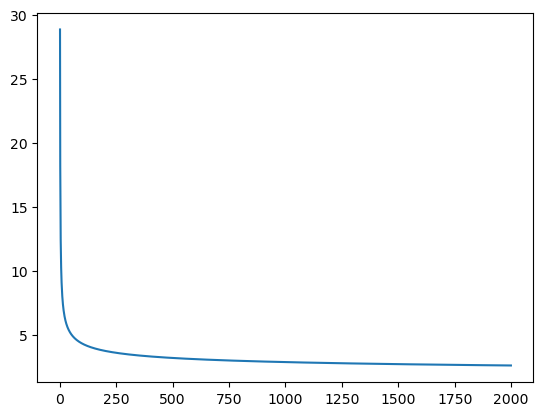

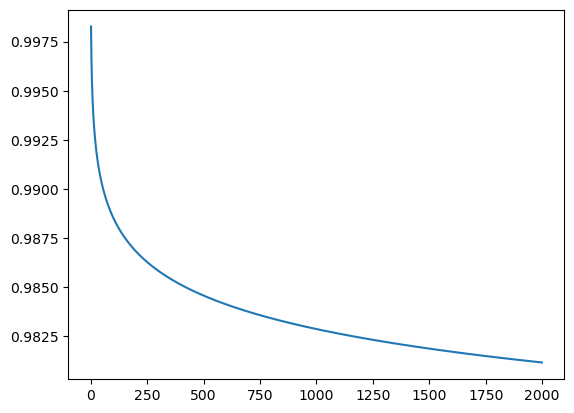

In [12]:
#Graph to test effect of delta and initial temperature on cooling schedule 
temperature = 20
initial_temperature = 20
ar = []
ir = []
pr = []
for i in range(1, 2000):
    temperature =  initial_temperature / (np.log(i + 1))
    ar.append(temperature)
    ir.append(i)
    argument = -0.05 / temperature
    pr.append(math.exp(argument))
plt.plot(ir, ar)
plt.show()
plt.plot(ir, pr)

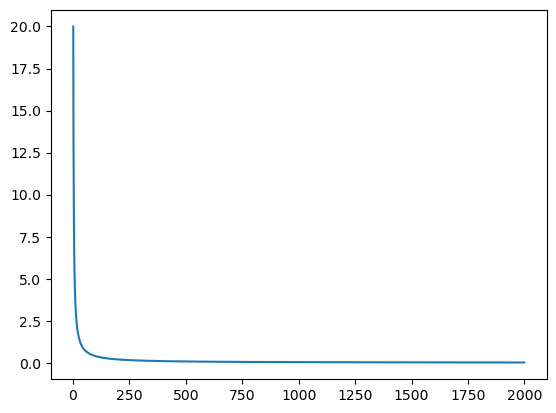

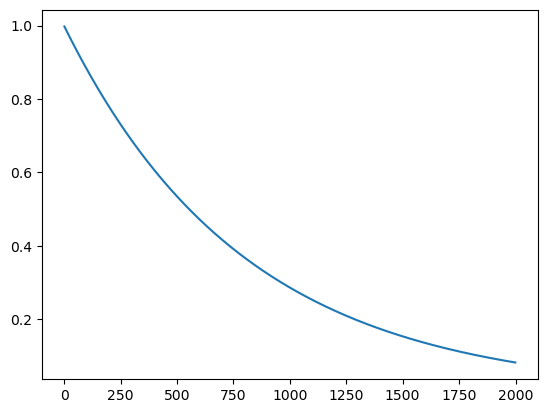

In [442]:
#Graph to test effect of delta and initial temperature on cooling schedule 
temperature = 20
initial_temperature = 40
ar = []
ir = []
pr = []
for i in range(1, 2000):
    temperature =  initial_temperature / (1 + i)
    ar.append(temperature)
    ir.append(i)
    argument = -0.05 / temperature
    pr.append(math.exp(argument))

plt.plot(ir, ar)
plt.show()
plt.plot(ir, pr)

In [200]:
# Move part of the tour to the different spot
def move_part(route):
    i, j = sorted(random.sample(range(1, len(route)-1), 2))
    route_slice = route[i:j]
    del route[i:j]
    if len(route) - 1 > 0:
        new_position = random.randint(1, len(route) - 1)
    else:
        new_position = 1
    route[new_position:new_position] = route_slice
    return route


In [13]:
#Logarithmic cooling
def Hoffmann_Salamon_cooling(iter, D = 10):
        return (D-1)/math.log(iter + 2)

In [14]:
#Exponential cooling
def exponential_cooling(temp, rate):
        return temp*rate

In [15]:
# Fast cooling
def fast_cooling(iteatr, initial):
        return initial/(1+iteatr)

In [341]:
@timeit
def simulated_annealing(cities, initial_temperature, cooling_rate):
    """Simulated annealing algorithm"""
    num_cities = len(cities)
    current_tour = list(range(num_cities))
    current_distance = calculate_total_distance(current_tour, cities)
    best_tour = current_tour[:]
    best_distance = current_distance
    temperature = initial_temperature
    temp_array = []
    prob_array = []
    t = []
    fitnes = []
    fitnes_t = []
    temp_t = []
    bb = []
    no_progress = 0
    """Outer loop to decrease schedule"""
    for inner_ier in range(3000):
      a = [1,1,2,3,3,4]
      """Inner loop (Markov Chain length)"""
      for iteration in range(2000):
        new_tour = current_tour[:]
        u = random.sample(a, 1)
        if u[0] == 1:
            # 2opt swap
            tik = 1
            i, j = sorted(random.sample(range(1, num_cities), 2))
            new_tour[i:j+1] = list(reversed(new_tour[i:j+1]))
        elif u[0] == 2:
            #move city 
            tik = 2
            new_tour = move_city(new_tour)
        elif u[0] == 3:
            #move part
            tik = 3
            new_tour = move_part(new_tour)
        elif u[0] == 4:
            # Reverse two adjacent neigbours
            tik = 4
            i, j = random.sample(range(1, num_cities), 2)
            tem = new_tour[i]
            try: 
                new_tour[i] = new_tour[i+1]
                new_tour[i+1] = tem
            except: 
                new_tour[i] = new_tour[i-1]
                new_tour[i-1] = tem
        # calculate the new tour distance
        new_distance = calculate_total_distance(new_tour, cities)
        delta_distance = new_distance - current_distance
        # decide whether to accept the new tour
        if delta_distance <= 0:
            #a.append(tik)
            fitnes.append(new_distance)
            fitnes_t.append((inner_ier)*2000 +iteration) 
            bb.append(best_distance)
            current_tour = new_tour
            current_distance = new_distance
            # update the best tour if needed
            if new_distance < best_distance:
                best_tour = new_tour
                best_distance = new_distance
                print(best_distance)
                no_progress =0
            else:
                no_progress += 1
        else:
            no_progress += 1
            argument = -delta_distance / temperature
            random_u = random.uniform(0, 1)
            prob_array.append(math.exp(argument))
            t.append((inner_ier)*2000 +iteration) 
            if math.exp(argument) > random_u:
                current_tour = new_tour
                current_distance = new_distance

            

      temperature = exponential_cooling(temperature, cooling_rate)
      #print(temperature)
      # Reaneiling
      if temperature < 0.1 and no_progress > 50:
       best_route_2opt = optimise_with_2opt(best_tour, cities)
       best_dist_2opt = calculate_total_distance(best_route_2opt, cities)
       if best_dist_2opt == best_distance:
            temperature = 3
            print("gg")
      temp_array.append(temperature)
      temp_t.append(inner_ier)                       
      
    return best_tour, best_distance ,temp_array, prob_array, t, fitnes, fitnes_t, temp_t, bb

In [18]:
tor = [1,
2,
242,
243,
244,
241,
240,
239,
238,
237,
236,
235,
234,
233,
232,
231,
246,
245,
247,
250,
251,
230,
229,
228,
227,
226,
225,
224,
223,
222,
221,
220,
219,
218,
217,
216,
215,
214,
213,
212,
211,
210,
207,
206,
205,
204,
203,
202,
201,
198,
197,
196,
195,
194,
193,
192,
191,
190,
189,
188,
187,
186,
185,
184,
183,
182,
181,
176,
180,
179,
150,
178,
177,
151,
152,
156,
153,
155,
154,
129,
130,
131,
20,
21,
128,
127,
126,
125,
124,
123,
122,
121,
120,
119,
157,
158,
159,
160,
175,
161,
162,
163,
164,
165,
166,
167,
168,
169,
170,
172,
171,
173,
174,
107,
106,
105,
104,
103,
102,
101,
100,
99,
98,
97,
96,
95,
94,
93,
92,
91,
90,
89,
109,
108,
110,
111,
112,
88,
87,
113,
114,
115,
117,
116,
86,
85,
84,
83,
82,
81,
80,
79,
78,
77,
76,
75,
74,
73,
72,
71,
70,
69,
68,
67,
66,
65,
64,
58,
57,
56,
55,
54,
53,
52,
51,
50,
49,
48,
47,
46,
45,
44,
59,
63,
62,
118,
61,
60,
43,
42,
41,
40,
39,
38,
37,
36,
35,
34,
33,
32,
31,
30,
29,
28,
27,
26,
22,
25,
23,
24,
14,
15,
13,
12,
11,
10,
9,
8,
7,
6,
5,
4,
277,
276,
275,
274,
273,
272,
271,
16,
17,
18,
19,
132,
133,
134,
270,
269,
135,
136,
268,
267,
137,
138,
139,
149,
148,
147,
146,
145,
199,
200,
144,
143,
142,
141,
140,
266,
265,
264,
263,
262,
261,
260,
259,
258,
257,
254,
253,
208,
209,
252,
255,
256,
249,
248,
278,
279,
3,
280
]

In [17]:
# Plot tour
def plot_tour(tour, cities):
    x = [cities[city][0] for city in tour]
    y = [cities[city][1] for city in tour]
    x.append(x[0])
    y.append(y[0])
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, 'o-', label='Tour Path')
    plt.plot([cities[i][0] for i in range(len(cities))], 
             [cities[i][1] for i in range(len(cities))], 
             'o', label='Cities')
    
    plt.title('Traveling Salesman Problem - Simulated Annealing')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.legend()
    plt.show()


In [19]:
os.getcwd()

'/Users/iliasoroka/Documents/Computattional science/Stochastic simulations/Assigments/simulated_annealing'

In [20]:
# the path to the folder containing the csv file
folder_path = 'TSP-Configurations/'

# the name of the csv file you want to read
file_name = 'a280.tsp.txt'

# combine the folder path and file name to create the file path
file_path = folder_path + file_name

#file_path = "/Users/aleksandar/Documents/GitHub/simulated_annealing/TSP-Configurations/eil51.tsp"

In [9]:
ls -l /Users/aleksandar/Documents/GitHub/simulated_annealing/TSP-Configurations/eil51.tsp.txt

ls: /Users/aleksandar/Documents/GitHub/simulated_annealing/TSP-Configurations/eil51.tsp.txt: No such file or directory


In [11]:
ls -l /Users/aleksandar/Documents/GitHub/simulated_annealing/TSP-Configurations/

total 72
-rw-r--r--@ 1 aleksandar  staff   1092 Jun  1  1995 a280.opt.tour.txt
-rw-r--r--@ 1 aleksandar  staff   3483 Jun  1  1995 a280.tsp.txt
-rw-r--r--@ 1 aleksandar  staff    257 Jun  1  1995 eil51.opt.tour.txt
-rw-r--r--@ 1 aleksandar  staff    579 Jun  1  1995 eil51.tsp.txt
-rw-r--r--@ 1 aleksandar  staff   1777 Jun  1  1995 pcb442.opt.tour.txt
-rw-r--r--@ 1 aleksandar  staff  12414 Jun  1  1995 pcb442.tsp.txt


In [21]:
# two opt swap for determenistic algorithm
def two_opt_swap(route, i, j):
    new_route = route[:i] + route[i:j + 1][::-1] + route[j + 1:]
    return new_route

In [22]:
# determenistic two opt swap
def optimise_with_2opt(route, cities):
    """The determenistic alg for 2-opt swap on best result."""
    improvement = True
    best_route = route
    best_distance = calculate_total_distance(route, cities)
    while improvement:
        improvement = False
        for i in range(1, len(best_route) - 1):
            for j in range(i + 1, len(best_route)):
                new_route = two_opt_swap(best_route, i, j)
                new_distance = calculate_total_distance(new_route, cities)
                if new_distance < best_distance:
                    best_distance = new_distance
                    best_route = new_route
                    improvement = True
                    break
            if improvement:
                break

    return best_route

In [793]:
# It takes too long to run, delete if we will not use it
def param_search(cities, initial_temp, cooling_rate, in_temp=0.05, col_rate=0.95, max_no_improve=30):
    """ Simulated aneiling to find best hyperparameters for TSP"""
    curr_temp = initial_temp
    curr_rate = cooling_rate
    best_tour, best_distance_init, temp_arr, prob, t, fit, ft, temp_t, best = simulated_annealing(cities, initial_temp, cooling_rate)
    
    temperature = in_temp
    best_abs = np.inf
    best_initial_temp = 0 
    best_cooling_rate = 0
    no_improve_counter = 0

    log = []

    for k in range(150):
        step_size_temp = 2.5 / (1 + k)  
        step_size_rate = 0.01 / (1 + k)  

        mean_len = []
        improved = False

        for i in range(4):
            u = random.uniform(-step_size_temp, step_size_temp) 
            new_temp = max(curr_temp + u, 0.1) 
            u = random.uniform(-step_size_rate, step_size_rate) 
            new_rate = min(max(curr_rate + u, 0.01), 0.999) 

            for b in range(7):
                best_tour, best_distance, temp_arr, prob, t, fit, ft, temp_t, best = simulated_annealing(cities, new_temp, new_rate)
                mean_len.append(best_distance)

            mean_len_v = np.mean(mean_len)
            delta_distance = mean_len_v - best_distance_init
            argument = -delta_distance / temperature
            random_u = random.uniform(0, 1)

            if delta_distance < 0 or math.exp(argument) > random_u:
                curr_temp = new_temp
                curr_rate = new_rate
                best_distance_init = mean_len_v
                print(step_size_temp)
                if best_distance_init < best_abs:
                    best_abs = best_distance_init
                    print(f"Abs best:{best_abs}")
                    print(f"cur temp:{temperature}")
                    print(f"new_temp :{new_temp}")
                    print(f"new_rate:{new_rate}")
                    best_initial_temp = curr_temp 
                    best_cooling_rate = curr_rate
                    improved = True

        log.append((k, curr_temp, curr_rate, best_abs))

        if not improved:
            no_improve_counter += 1
        else:
            no_improve_counter = 0

        if no_improve_counter >= max_no_improve:
            print("Stopping early due to no improvement.")
            break

        temperature *= col_rate

    return best_abs, best_initial_temp, best_cooling_rate, log


33947.111632542175
33728.97050851972
33667.05170482933
33590.1421999023
33494.48053400245
33427.733499849164
33385.14034208574
33120.36054578971
33120.25812562863
33044.80168325937
33001.27858865801
32923.889807919855
32847.465337232694
32836.75322459863
32715.01306805824
32534.325076817935
32508.18160931302
32352.21868957754
32322.189741849466
32285.504923629105
32202.138094864356
31845.24853519872
31693.503248309597
31693.47833970982
31609.456185395233
31571.072001970653
31565.274785476326
31504.32872110241
31415.679044774723
31341.862191755845
31300.13165201872
31274.82057650736
31174.539046870224
31092.145600131826
31049.379545348234
31045.450491523694
31039.66298091436
30988.069190414284
30844.0130902126
30732.800969738444
30592.874270486565
30592.06652417088
30541.519264559236
30466.93627159484
30417.664886717004
30412.247014629178
30404.71968635015
30271.28861379878
30179.61214661689
30074.024637778846
29919.942304775093
29868.354445761073
29768.702977857247
29744.7477117074
296

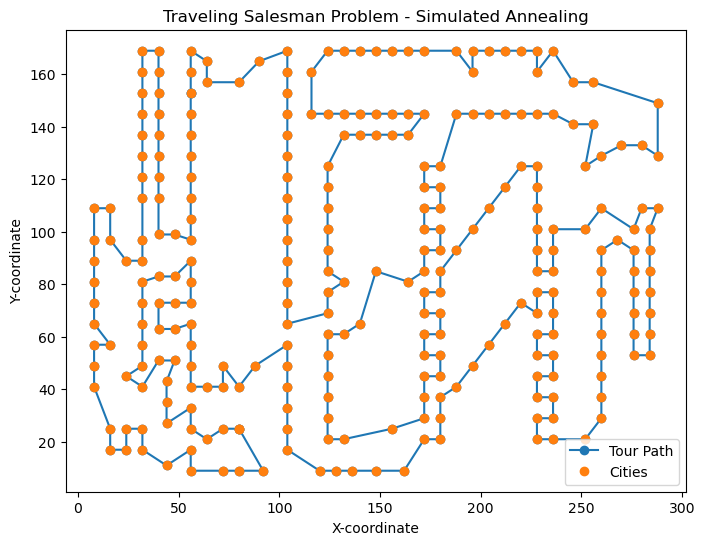

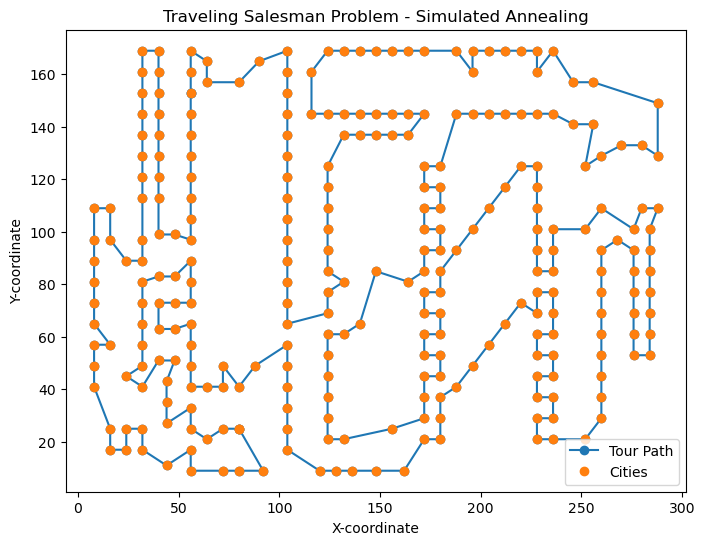

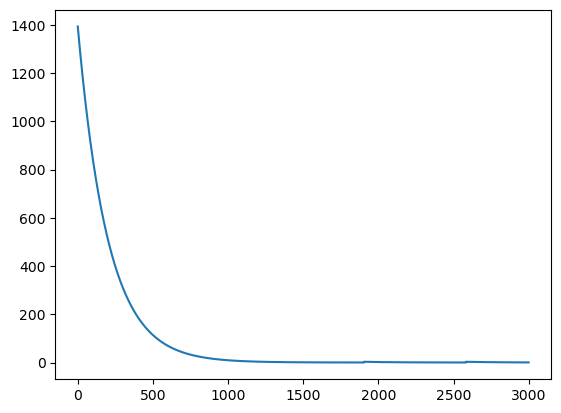

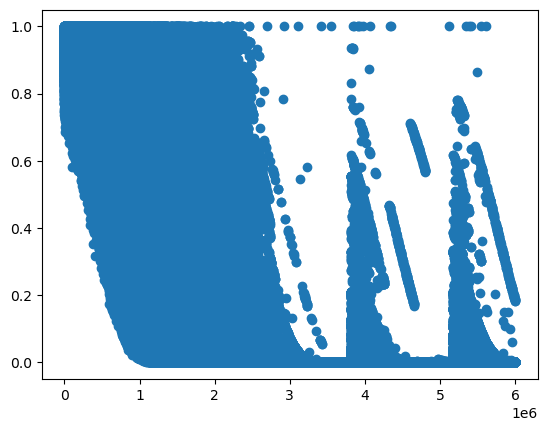

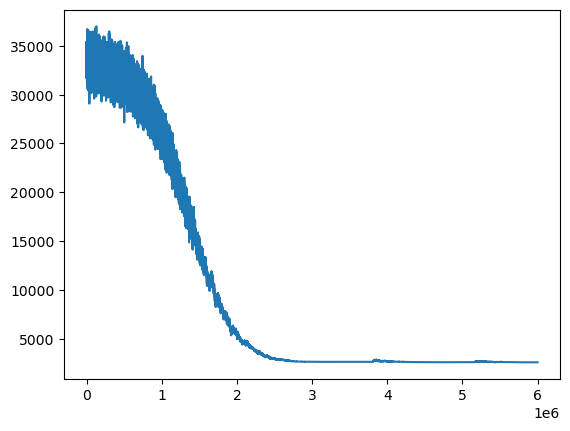

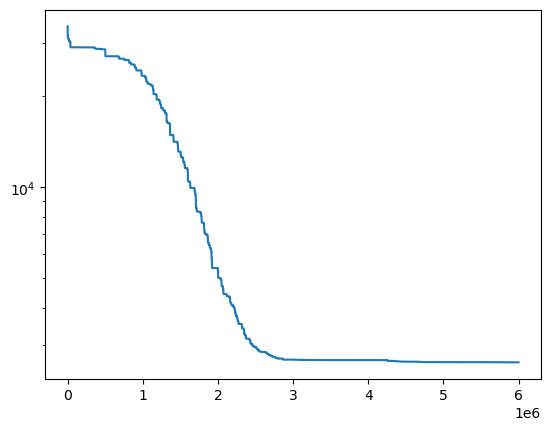

In [344]:
# Run simulation
if __name__ == "__main__":
    tsp_file_path = file_path
    cities = read_tsp_file(tsp_file_path)
    random.shuffle(cities)
    initial_temp = 1400
    cooling_rate = 0.995
    best_tour, best_distance, temp_arr, prob, t, fit, ft, temp_t, best = simulated_annealing(cities,initial_temp,cooling_rate )
    best_distance = calculate_total_distance(best_tour, cities)
    best_route_2opt = optimise_with_2opt(best_tour, cities)
    best_dist_2opt = calculate_total_distance(best_route_2opt, cities)
    print("Best Tour:", best_tour)
    print("Best Distance:", best_distance)
    print("Best Distance_2opt:", best_dist_2opt)
    plot_tour(best_tour, cities)
    plot_tour(best_route_2opt, cities)
    plt.plot(temp_t, temp_arr)
    plt.show()
    plt.scatter(t, prob)
    plt.show()
    plt.plot(ft, fit)
    plt.show()
    plt.plot(ft, best)
    plt.yscale('log')
    plt.show()

In [676]:
print(abs_best)

2583.0571187244327


In [282]:
def two_opt(tour):
    # apply 2-opt move
    i, j = random.sample(range(len(tour)), 2)
    i, j = sorted([i, j])
    new_tour = tour[:i] + tour[i:j+1][::-1] + tour[j+1:]
    return new_tour

In [283]:
def move_city(tour):
    # apply move of a single city
    i, j = random.sample(range(len(tour)), 2)
    city = tour.pop(i)
    tour.insert(j, city)
    return tour

In [284]:
def simulated_annealing_tomc(cities, initial_temperature=1000, cooling_rate=0.995, num_iterations=10000):
    num_cities = len(cities)
    current_tour = list(range(num_cities))
    random.shuffle(current_tour)
    current_distance = calculate_total_distance(current_tour, cities)

    best_tour = current_tour[:]
    best_distance = current_distance

    temperature = initial_temperature

    for iteration in range(num_iterations):
        # Choose a random elementary edit
        if random.uniform(0, 1) < 0.5:
            new_tour = two_opt(current_tour)
        else:
            new_tour = move_city(current_tour)

        # Calculate the new tour distance
        new_distance = calculate_total_distance(new_tour, cities)

        # Decide whether to accept the new tour
        if new_distance < current_distance or random.uniform(0, 1) < math.exp((current_distance - new_distance) / temperature):
            current_tour = new_tour
            current_distance = new_distance

            # Update the best tour if needed
            if new_distance < best_distance:
                best_tour = new_tour
                best_distance = new_distance

        # Cool down the temperature
        temperature *= cooling_rate

    return best_tour, best_distance

In [574]:

def plot_tour(tour, cities):
    x = [cities[city][0] for city in tour]
    y = [cities[city][1] for city in tour]
    x.append(x[0])
    y.append(y[0])
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, 'o-', label='Tour Path')
    plt.plot([cities[i][0] for i in range(len(cities))], 
             [cities[i][1] for i in range(len(cities))], 
             'o', label='Cities')
    
    plt.title('Traveling Salesman Problem - Simulated Annealing')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.legend()
    plt.show()


Best Tour: [38, 24, 27, 22, 12, 18, 39, 14, 33, 0, 9, 41, 13, 23, 3, 44, 50, 20, 28, 26, 16, 15, 21, 19, 34, 46, 10, 37, 40, 43, 47, 31, 25, 42, 48, 1, 6, 2, 30, 45, 5, 8, 29, 49, 32, 36, 4, 35, 7, 11, 17]
Best Distance: 1315.3790499546542


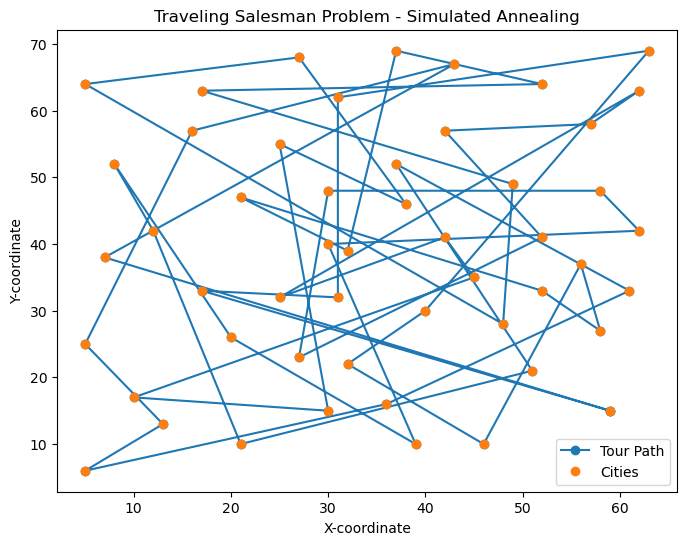

In [576]:
if __name__ == "__main__":
    tsp_file_path = file_path
    cities = read_tsp_file(tsp_file_path)
    best_tour, best_distance = simulated_annealing_tomc(cities)
    print("Best Tour:", best_tour)
    print("Best Distance:", best_distance)
    plot_tour(best_tour, cities)

In [577]:
def run_multiple_simulations(cities, num_simulations=100):
    best_overall_tour = None
    best_overall_distance = float('inf')

    for i in range(num_simulations):
        #print(f"Running Simulation {i + 1}")
        current_tour, current_distance = simulated_annealing(cities)
        if current_distance < best_overall_distance:
            best_overall_tour = current_tour
            best_overall_distance = current_distance

    return best_overall_tour, best_overall_distance

In [1983]:
if __name__ == "__main__":
    tsp_file_path = file_path
    cities = read_tsp_file(tsp_file_path)

    best_tour, best_distance = run_multiple_simulations(cities, num_simulations=100)

    print("Best Tour:", best_tour)
    print("Best Distance:", best_distance)

    plot_tour(best_tour, cities)

0.9949127291999671
0.9948132379270471
0.9947137566032545
0.9946142852275941
0.9945148237990713
0.9944153723166914
0.9943159307794598
0.9942164991863819
0.9941170775364633
0.9940176658287097
0.9939182640621268
0.9938188722357206
0.993719490348497
0.9936201183994622
0.9935207563876223
0.9934214043119836
0.9933220621715524
0.9932227299653352
0.9931234076923388
0.9930240953515695
0.9929247929420344
0.9928255004627402
0.992726217912694
0.9926269452909028
0.9925276825963737
0.9924284298281141
0.9923291869851313
0.9922299540664328
0.9921307310710261
0.992031517997919
0.9919323148461192
0.9918331216146347
0.9917339383024733
0.991634764908643
0.9915356014321521
0.9914364478720089
0.9913373042272218
0.9912381704967991
0.9911390466797494
0.9910399327750814
0.9909408287818039
0.9908417346989258
0.9907426505254558
0.9906435762604033
0.9905445119027773
0.990445457451587
0.9903464129058418
0.9902473782645512
0.9901483535267248
0.9900493386913721
0.989950333757503
0.9898513387241272
0.9897523535902548

ValueError: too many values to unpack (expected 2)